In [6]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import tensorflow as tf
from copy import deepcopy
from tqdm import tqdm


from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from tensorflow.python.ops import gen_audio_ops as audio_ops
#from tensorflow.op.audio import Mfcc
from tensorflow.python.util import compat

import io
#tf.compat.v1.disable_eager_execution()


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [7]:
class config:
  DIRECTORY_PATH = "./KeyWord Spotting"
  DATADIR_PATH = DIRECTORY_PATH + "/data"
  BASELINE_CHECKPOINT_PATH = DIRECTORY_PATH + "/models/"
  POST_TRAINING_QUANTIZATION_PATH = DIRECTORY_PATH + "/models/post_training_quantization"

  TRAINING_DATA_SIZE = 0.8
  VALIDATION_DATA_SIZE = 0.2
  TEST_DATA_SIZE = 0.2
  BATCH_SIZE = 64
  NUM_EPOCHS = 150
  LEARNING_RATE = 0.0001

class Params:
  sample_rate: float
  stft_window_useconds : float
  stft_hop_useconds: float
  mel_bands : int
  mel_min_hz : float
  mel_max_hz : float
  log_offset : float = 0.001
  patch_window_seconds : float = 0.96
  path_hop_seconds : float = 0.48

  def __init__(self, sample_rate,stft_window,stft_hop,mel_bins,min_hz,max_hz):
     self.sample_rate = sample_rate
     self.stft_window_useconds = stft_window
     self.stft_hop_useconds = stft_hop
     self.mel_bands = mel_bins
     self.mel_min_hz = min_hz
     self.mel_max_hz = max_hz

  @property
  def patch_frames(self):
    return (int(round(self.patch_window_seconds / self.stft_hop_seconds)))

mel_bins =40
max_hz = 8000
min_hz = 0
stft_window =30
stft_hop = 10
sample_rate = 16000

_params = Params(sample_rate,stft_window,stft_hop,mel_bins,min_hz,max_hz)
kws_config = config


In [12]:
def download_data(data_dir):
  """
  Function to load the train and test dataset
  """
  if not data_dir.exists():
    tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir=data_dir)

def get_commands(data_dir):
  """
  Function to load labels
  """
  if pathlib.Path(data_dir).exists():
     commands = np.array(tf.io.gfile.listdir(str(data_dir)))
     commands = commands[commands != 'README.md']
     print('Commands:', commands)
     return commands

In [25]:
def get_audio(data_dir):
  """
   function to extract the audio files and into a list
  """
  files = []
  #for i in commands:
  #  filenames += tf.io.gfile.glob(str(data_dir) + '/' + i + '/*')
  files = tf.io.gfile.glob(str(data_dir) + '/*/*')
  files = tf.random.shuffle(files)
  num_samples = len(files)
  print('Number of total examples:', num_samples)
  commands = get_commands(data_dir)
  print('Number of examples per label:',
          len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
  return files

#go_filenames = tf.io.gfile.glob(str(data_dir) + '/go/*')
#no_filenames = tf.io.gfile.glob(str(data_dir) + '/no/*')
#print('Example file tensor:', filenames[0])

# Obtain Training and Validation Data Splits
def get_data_split(data_dir):
  """
   Obtain Training and Validation Data Splits
  """
  download_data(pathlib.Path(data_dir))
  data_dir = data_dir + '/mini_speech_commands'
  audio_files = get_audio(pathlib.Path(data_dir))
  total_data = len(audio_files)
  train_size = int(kws_config.TRAINING_DATA_SIZE*total_data)
  val_size = int(kws_config.VALIDATION_DATA_SIZE*total_data)
  test_size = int(kws_config.TEST_DATA_SIZE*total_data)
  train_files = audio_files[:train_size]
  val_files = audio_files[train_size:train_size+val_size]
  test_files = audio_files[-test_size:]
  print('Training set size', len(train_files))
  print('Validation set size', len(val_files))
  print('Test set size', len(test_files))
  return train_files,val_files,test_files


In [10]:
#reading audio files
# tf.audio.decode_wav convert wav file to numberical tensor

# sample rate of the wave is 16khz values representing (amplitude) -32768, 32767
#tf.audio.decode_wav normalize the values to the range [-1,1]

def decode_audio(audio_wave):
  audio_wav, _ = tf.audio.decode_wav(audio_wave,desired_channels=1,desired_samples=16000)
  return tf.squeeze(audio_wav, axis=-1)
  #foreground_volume_placeholder_ = tf.compat.v1.placeholder(
  #        tf.float32, [], name='foreground_volume')
  #scaled_foreground = tf.multiply(audio_wave,
  #                                    foreground_volume_placeholder_)
      # Shift the sample's start position, and pad any gaps with zeros.
  #time_shift_padding_placeholder_ = tf.compat.v1.placeholder(
  #        tf.int32, [2, 2], name='time_shift_padding')
  #time_shift_offset_placeholder_ = tf.compat.v1.placeholder(
  #        tf.int32, [2], name='time_shift_offset')
  #padded_foreground = tf.pad(
  #        tensor=scaled_foreground,
  #        paddings=time_shift_padding_placeholder_,
  #        mode='CONSTANT')
  #sliced_foreground = tf.slice(padded_foreground,
  #                                 time_shift_offset_placeholder_,
  #                                 [desired_samples, -1])

#get label for wave
def get_label(file_path):
   parts = tf.strings.split(file_path,os.path.sep)

#you will use indexing here instead of tuple unpacking to enable this to in
#work in a tensorflow graph
   return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_bin = tf.io.read_file(file_path)
  waveform= decode_audio(audio_bin)
  return waveform,label

In [ ]:
train_files,val_files,test_files = get_data_split(kws_config.DATADIR_PATH)



In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

gofiles_ds = tf.data.Dataset.from_tensor_slices(go_filenames)
nofiles_ds = tf.data.Dataset.from_tensor_slices(no_filenames)

gowaveform_ds = gofiles_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
nowaveform_ds = nofiles_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [ ]:
rows = 5
cols = 5
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 22))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  print('Waveform shape:', tf.shape(audio))
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-2.2, 2.2, 0.4))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)
plt.show()

In [ ]:
#normailize inputs

def normalize_waveforms(x):
    """ notmalize each waveform of a set

    parameters:
    x: the dataset to normalize

    returns:

    the same set with each waveform normalized
    """

    max_nums = np.max(np.absolute(x),axis=1)
    zeros = np.where(max_nums==0)
    max_nums[zeors] = 1
    return x/max_nums[:,None]

def normalize_spectrograms(x):
    """Normalize each spectrogram of a set
    Parameters:
    x: the dataset to normalize
    Returns:
    The same set with each spectrogram normalized.
    """
    x_2 = np.zeros_like(x)
    for i, example in enumerate(x):
        x_2[i] = example/np.max(np.abs(example))

    return x_2


def normalize_2D(x):
    """Normalize a 2D image
    """

    x_2 = deepcopy(x)
    eps = 1e-10

    means = np.mean(x_2, axis = (1,2))
    std = np.std(x_2,axis = (1,2))

    return (x_2-means[:,None,None])/(std[:,None,None]+eps)

def make_oh(y):
    N = len(y)
    n_classes = len(np.unique(y))

    y_oh = np.zeros((N,n_classes))

    for i in range(N):
        col = int(y[i])
        y_oh[i,col] = 1

    return y_oh

In [ ]:
#spectrgram conversio
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([_params.sample_rate] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  window_size_samples = int(16000*_params.stft_window_useconds/1000)
  window_size_stride =  int(16000*_params.stft_hop_useconds/1000)
  fft_length = 2 ** int(np.ceil(np.log(window_size_samples)/ np.log(2.0)))
  spectrogram = tf.signal.stft(
     equal_length, frame_length=window_size_samples, frame_step=window_size_stride,fft_length=fft_length)
  print('Spectrogram shape:', spectrogram.shape)
  #spectrogram = audio_ops.audio_spectrogram(equal_length,window_size_samples,window_size_stride,magnitude_squared=True)
  spectrogram = tf.abs(spectrogram)
  # Warp the linear scale spectrograms into the mel-scale.
  num_spectrogram_bins = fft_length // 2 + 1
  print("number of mel_bands", num_spectrogram_bins)
  lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 40
  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      _params.mel_bands, num_spectrogram_bins, _params.sample_rate, _params.mel_min_hz,_params.mel_max_hz)

  #mel_spectrograms = tf.tensordot(
  #          spectrogram, linear_to_mel_weight_matrix, 1)

  mel_spectrograms = tf.matmul(spectrogram, linear_to_mel_weight_matrix)
  mel_spectrograms.set_shape(spectrogram.shape[:-1].concatenate(
                linear_to_mel_weight_matrix.shape[-1:]))


  # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
  log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

  print("mel_spectrogram_shape", log_mel_spectrograms.shape)

  # Compute MFCCs from log_mel_spectrograms and take the first 40.
  mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
        log_mel_spectrograms)[..., :64]

  spectrogram = tf.abs(spectrogram)
  print('mfcc shape:', mfccs.shape)
  return spectrogram,mfccs


In [ ]:
#mel spectrgram conversion
def get_melspectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([_params.sample_rate] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  window_size_samples = int(16000*_params.stft_window_useconds/1000)
  window_size_stride =  int(16000*_params.stft_hop_useconds/1000)
  fft_length = 2 ** int(np.ceil(np.log(window_size_samples)/ np.log(2.0)))
  spectrogram = tf.signal.stft(
     equal_length, frame_length=window_size_samples, frame_step=window_size_stride,fft_length=fft_length)
  print('Spectrogram shape:', spectrogram.shape)
  #spectrogram = audio_ops.audio_spectrogram(equal_length,window_size_samples,window_size_stride,magnitude_squared=True)
  spectrogram = tf.abs(spectrogram)
  # Warp the linear scale spectrograms into the mel-scale.
  num_spectrogram_bins = fft_length // 2 + 1
  print("number of mel_bands", num_spectrogram_bins)
  lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 40
  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      _params.mel_bands, num_spectrogram_bins, _params.sample_rate, _params.mel_min_hz,_params.mel_max_hz)

  #mel_spectrograms = tf.tensordot(
  #          spectrogram, linear_to_mel_weight_matrix, 1)

  mel_spectrograms = tf.matmul(spectrogram, linear_to_mel_weight_matrix)
  mel_spectrograms.set_shape(spectrogram.shape[:-1].concatenate(
                linear_to_mel_weight_matrix.shape[-1:]))


  # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
  log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

  print("mel_spectrogram_shape", log_mel_spectrograms.shape)

  spectrogram = tf.abs(spectrogram)
  return spectrogram,log_mel_spectrograms

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram,mfccs = get_spectrogram(waveform)

for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram,mel_spectrograms = get_melspectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(4, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
axes[2].set_title('mel_spectrogram')
plot_spectrogram(mel_spectrograms.numpy(),axes[2])
axes[3].set_title('mfcc')
#spectrogram = tf.expand_dims(spectrogram,-1)
#mfcc = audio_ops.mfcc(spectrogram,16000,dct_coefficient_count=129)
plot_spectrogram(mfccs.numpy(),axes[3])
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram,mfccs= get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  #mfccs = tf.expand_dims(mfccs,1)
  label_id = tf.argmax(label == commands)
  return spectrogram,label_id

def get_melspectrogram_and_label_id(audio, label):
  _,mel_spectrogram= get_melspectrogram(audio)
  mel_spectrogram = tf.expand_dims(mel_spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return mel_spectrogram,label_id

def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

def get_mfcc_and_label_id(audio, label):
  spectrogram,mfccs = get_spectrogram(audio)
  #spectrogram = tf.expand_dims(spectrogram, -1)
  mfccs = tf.expand_dims(mfccs,-1)
  label_id = tf.argmax(label == commands)
  return  mfccs, label_id

def preprocess_mfccdataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_mfcc_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

def preprocess_meldataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_melspectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
def plot_mfccspectrogram(wave_ds):

   rows = 5
   cols = 3
   n = rows
   for i, (audio, label) in enumerate(wave_ds.take(n)):
      fig, axes = plt.subplots(3, figsize=(12, 10))
      print('Waveform shape:', tf.shape(audio))
      spectrogram,mfccs = get_spectrogram(audio)
      timescale = np.arange(audio.shape[0])
      axes[0].plot(timescale,audio.numpy())
      label = label.numpy().decode('utf-8')
      axes[0].set_title(label)
      axes[0].set_xlim([0, 16000])
      plot_spectrogram(spectrogram.numpy(),axes[1])
      axes[1].set_title("spectrogram")
      plot_spectrogram(mfccs.numpy(),axes[2])
      axes[2].set_title("mfcc")

   plt.show()

In [ ]:
rows = 5
cols = 3
n = rows

for i, (audio, label) in enumerate(nowaveform_ds.take(n)):
  fig, axes = plt.subplots(3, figsize=(12, 10))
  print('Waveform shape:', tf.shape(audio))
  spectrogram,mfccs = get_spectrogram(audio)
  timescale = np.arange(audio.shape[0])
  axes[0].plot(timescale,audio.numpy())
  label = label.numpy().decode('utf-8')
  axes[0].set_title(label)
  axes[0].set_xlim([0, 16000])
  plot_spectrogram(spectrogram.numpy(),axes[1])
  axes[1].set_title("spectrogram")
  plot_spectrogram(mfccs.numpy(),axes[2])
  axes[2].set_title("mfcc")

plt.show()

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

rows = 5
cols = 5
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  print("spectrogram_shape",spectrogram.shape)
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()



In [ ]:

mfcc_ds = waveform_ds.map(
    get_mfcc_and_label_id, num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (mfccs, label_id) in enumerate(mfcc_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  print("mfcc_shape",mfccs.shape)
  plot_spectrogram(np.squeeze(mfccs.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

Spectrogram shape: (98, 257)
number of mel_bands 257
mel_spectrogram_shape (98, 40)
melspectrogram_shape (98, 40, 1)
melspectrogram_shape (98, 40, 1)
melspectrogram_shape (98, 40, 1)
melspectrogram_shape (98, 40, 1)
melspectrogram_shape (98, 40, 1)
melspectrogram_shape (98, 40, 1)
melspectrogram_shape (98, 40, 1)
melspectrogram_shape (98, 40, 1)
melspectrogram_shape (98, 40, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


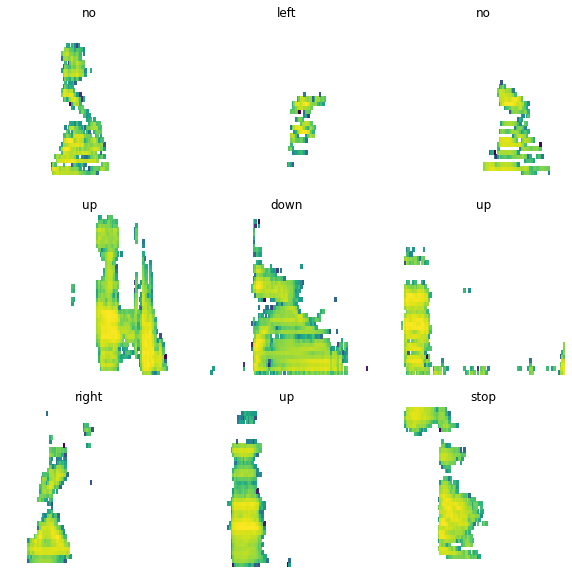

In [ ]:
mel_spectrogram_ds = waveform_ds.map(
    get_melspectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (mels, label_id) in enumerate(mel_spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  print("melspectrogram_shape",mels.shape)
  plot_spectrogram(np.squeeze(mels.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

Spectrogram shape: (98, 257)
number of mel_bands 257
mel_spectrogram_shape (98, 40)
mfcc shape: (98, 40)
Spectrogram shape: (98, 257)
number of mel_bands 257
mel_spectrogram_shape (98, 40)
mfcc shape: (98, 40)


In [ ]:
train_ds = mfcc_ds
val_ds = preprocess_mfccdataset(val_files)
test_ds = preprocess_mfccdataset(test_files)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


In [ ]:
train_ds = mel_spectrogram_ds
val_ds = preprocess_meldataset(val_files)
test_ds = preprocess_meldataset(test_files)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
from keras import backend as K
from keras import backend as K
from keras.layers.core import Activation
from keras.utils.generic_utils import get_custom_objects

def mexican_hat_wt(x):
    x = (x-t_1)
    tf_pi = K.constant(np.pi,dtype=tf.float32)
    #f = tf.constant(0.1, dtype = tf.float32)
    #return (1-x**2)*tf.exp(-x**2)
    return (1-2*(tf_pi**2)*(d_1**2)*(x**2))*K.exp(-(tf_pi**2)*(d_1**2)*x**2)


get_custom_objects().update({'mexican_hat_wt': Activation(mexican_hat_wt)})

In [ ]:


for mfcc, _ in mfcc_ds.take(1):
  input_shape = mfcc.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(mfcc_ds.map(lambda x, _: x))

model_mfcc = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Conv2D(64, kernel_size=(8,8), padding='valid', strides=(1,1), activation='relu'),
    layers.MaxPooling2D(pool_size=(1,1)),
    layers.LayerNormalization(),
    layers.Conv2D(48, kernel_size=(4,4), padding='valid', strides=(1,1), activation='relu'),
    layers.MaxPooling2D(pool_size=(1,1)),
    layers.LayerNormalization(),
    layers.GlobalMaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels),
])

model_mfcc.summary()



Input shape: (98, 40, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 98, 40, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 33, 64)        4160      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 91, 33, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 91, 33, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 88, 30, 48)        49200     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 30, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (N

In [ ]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()
def lr_scheduler(epoch, lr):
    if epoch > 4:
        lr = 0.0001 *  tf.math.exp(0.1 * (7 - epoch))
        return lr
    return lr

#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=0.001,
#    decay_steps=10000,
#    decay_rate=0.9)

model_mfcc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=100000,
#    decay_rate=0.96,
#    staircase=True)

EPOCHS = 100
history = model_mfcc.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
               tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),]
)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 266s 3s/step - loss: 1.4375 - accuracy: 0.4936 - val_loss: 1.9845 - val_accuracy: 0.3650
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 239s 2s/step - loss: 0.6159 - accuracy: 0.7902 - val_loss: 1.7558 - val_accuracy: 0.3713
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 230s 2s/step - loss: 0.4199 - accuracy: 0.8606 - val_loss: 1.2495 - val_accuracy: 0.7025
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 226s 2s/step - loss: 0.3507 - accuracy: 0.8816 - val_loss: 0.8419 - val_accuracy: 0.7538
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0010000000474

In [ ]:
#test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model_mfcc.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

NameError: ignored

In [ ]:
for spectrogram, _ in mel_spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Conv2D(64, kernel_size=(20,8), activation='relu'),
    layers.MaxPooling2D(pool_size=(1,3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(10,4), activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.GlobalMaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32),
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.25),
    layers.Dense(num_labels),
])

model.summary()

In [ ]:
for spectrogram, _ in mfcc_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(mfcc_ds.map(lambda x, _: x))

model_mfcc = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Conv2D(64, kernel_size=(20,8), activation='relu',use_bias=True),
    layers.MaxPooling2D(pool_size=(1,3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(10,4), activation='relu', use_bias=True),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.GlobalMaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32),
    layers.Dense(128, activation='relu',use_bias=True),
    #layers.Dropout(0.25),
    layers.Dense(num_labels),

])

model_mfcc.summary()

Input shape: (98, 40, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 98, 40, 1)         3         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 79, 33, 64)        10304     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 79, 11, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 79, 11, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 8, 64)         163904    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 4, 64)         0         
_________________________________________________________________
batch_normalization_3 (Batch 

In [ ]:
#Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()
def lr_scheduler(epoch, lr):
    if epoch > 4:
        lr = 0.0001 *  tf.math.exp(0.1 * (7 - epoch))
        return lr
    return lr

#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=0.001,
#    decay_steps=10000,
#    decay_rate=0.9)

model_mfcc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=100000,
#    decay_rate=0.96,
#    staircase=True)

EPOCHS = 100
history = model_mfcc.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
               tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),]
)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 137s 1s/step - loss: 1.0644 - accuracy: 0.6413 - val_loss: 1.6689 - val_accuracy: 0.5200
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 136s 1s/step - loss: 0.4189 - accuracy: 0.8591 - val_loss: 1.0967 - val_accuracy: 0.7425
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 137s 1s/step - loss: 0.2966 - accuracy: 0.9020 - val_loss: 0.7135 - val_accuracy: 0.7812
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 139s 1s/step - loss: 0.2366 - accuracy: 0.9208 - val_loss: 0.3759 - val_accuracy: 0.8875
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0010000000474

In [ ]:
for spectrogram, _ in mel_spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model_3conv = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Conv2D(64, kernel_size=(20,8), activation='relu'),
    layers.MaxPooling2D(pool_size=(1,3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(10,4), activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size=(5,2), activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.GlobalMaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels),
])

model_3conv.summary()

In [ ]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + '/metrics')
file_writer_image = tf.summary.create_file_writer(log_dir + "/images")
file_writer.set_as_default()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
def create_model(input_data,is_training,num_labels,dropout_rate):

    for input, _ in input_data.take(1):
       input_shape = input.shape
    print('Input shape:', input_shape)
    norm_layer = preprocessing.Normalization()
    norm_layer.adapt(input_data.map(lambda x, _: x))

    if is_training == True:

       model = models.Sequential([
           layers.Input(shape=input_shape),
           norm_layer,
           layers.Conv2D(64, kernel_size=(20,8), strides=(1,2),padding='valid', activation='relu',use_bias=True,bias_initializer='zeros'),
           layers.MaxPooling2D(pool_size=(1,3)),
           layers.BatchNormalization(),
           layers.Conv2D(64, kernel_size=(10,4), padding='valid', activation='relu',use_bias=True,bias_initializer='zero'),
           layers.MaxPooling2D(),
           layers.BatchNormalization(),
           layers.Flatten(),
           layers.Dense(32),
           layers.Dense(128, activation='relu'),
           layers.Dropout(dropout_rate),
           layers.Dense(num_labels),
        ])
    else:
       model = models.Sequential([
           layers.Input(shape=input_shape),
           #preprocessing.Resizing(32, 40),
           norm_layer,
           layers.Conv2D(64, kernel_size=(20,8), activation='relu',use_bias=True,bias_initializer='zeros'),
           layers.MaxPooling2D(pool_size=(1,3)),
           layers.Conv2D(64, kernel_size=(10,4), activation='relu',use_bias=True,bias_initializer='zero'),
           layers.MaxPooling2D(),
           layers.Flatten(),
           layers.Dense(128, activation='relu'),
           layers.Dense(num_labels),
        ])

    return model



In [ ]:
def create_1convmodel(input_data,is_training,num_labels,dropout_rate):

    for input, _ in input_data.take(1):
       input_shape = input.shape
    print('Input shape:', input_shape)
    norm_layer = preprocessing.Normalization()
    norm_layer.adapt(input_data.map(lambda x, _: x))

    if is_training == True:

       model = models.Sequential([
           layers.Input(shape=input_shape),
           #preprocessing.Resizing(32, 40),
           norm_layer,
           layers.Conv2D(64, kernel_size=(16,8), strides=(8,1),activation='relu',use_bias=True,bias_initializer='zeros'),
           layers.MaxPooling2D(pool_size=(1,3)),
           layers.BatchNormalization(),
           layers.GlobalMaxPooling2D(),
           layers.Flatten(),
           layers.Dense(8,use_bias=True,bias_initializer='zeros'),
           layers.Dense(128, activation='relu',use_bias=True,bias_initializer='zeros'),
           layers.BatchNormalization(),
           layers.Dense(128, activation='relu',use_bias=True,bias_initializer='zeros'),
           layers.Dense(num_labels),
        ])
    else:
       model = models.Sequential([
           layers.Input(shape=input_shape),
           preprocessing.Resizing(32, 40),
           norm_layer,
           layers.Conv2D(54, kernel_size=(32,8), activation='relu',use_bias=True,bias_initializer='zeros'),
           layers.MaxPooling2D(pool_size=(1,3)),
           layers.Flatten(),
           layers.Dense(128, activation='relu'),
           layers.Dense(num_labels),
        ])

    return model



In [ ]:
def build_2cnnmodel(input_ds, image_size1,image_size2,padding='valid',pool1=(2,2), pool2=(2,2),dropout_rate1=0.5, dropout_rate2=0.5,
                    strides1=(1,1),strides2=(1,1),cnn1_features=64,cnn2_features=32,dnn_features1=128, dnn_features2=128,
                    kernel1_size=(3,3),kernel2_size=(3,3)):

   for input,_ in input_ds.take(1):
     input_shape = input.shape
   num_labels = len(commands)

   norm_layer = preprocessing.Normalization()
   norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

   model = models.Sequential([
        layers.Input(shape=input_shape),
        preprocessing.Resizing(image_size1,image_size2),
        norm_layer,
        layers.Conv2D(cnn1_features,padding=padding, kernel_size=kernel1_size, strides=strides1,activation='gelu',use_bias=True,bias_initializer='zeros'),
        layers.MaxPool2D(pool_size=pool1),
        layers.BatchNormalization(),
        layers.Conv2D(cnn2_features, padding=padding,kernel_size=kernel2_size, strides=strides2,activation='gelu',use_bias=True,bias_initializer='zeros'),
        layers.MaxPool2D(pool_size=pool2),
        layers.BatchNormalization(),
        layers.GlobalMaxPooling2D(),
        layers.Flatten(),
        layers.Dense(dnn_features2, activation='gelu',use_bias=True,bias_initializer='zeros'),
        layers.Dense(dnn_features1, activation='gelu',use_bias=True,bias_initializer='zeros'),
        layers.Dense(num_labels),])
   model.summary()
   return model

def build_1cnnmodel(input_ds, image_size1,image_size2,padding='valid',pool1=(2,2), pool2=(2,2),dropout_rate1=0.5, dropout_rate2=0.5,
                    strides1=(1,1),strides2=(1,1),cnn1_features=64,cnn2_features=32,dnn_features1=128, dnn_features2=128,
                    kernel1_size=(3,3),kernel2_size=(3,3)):

   for input,_ in input_ds.take(1):
     input_shape = input.shape
   num_labels = len(commands)

   norm_layer = preprocessing.Normalization()
   norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

   model = models.Sequential([
        layers.Input(shape=input_shape),
        preprocessing.Resizing(image_size1,image_size2),
        norm_layer,
        layers.Conv2D(cnn1_features,padding=padding, kernel_size=kernel1_size, strides=strides1,activation='relu',use_bias=True,bias_initializer='zeros'),
        layers.MaxPool2D(pool_size=pool1),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(dnn_features2, activation=None,use_bias=True,bias_initializer='zeros'),
        layers.Dense(dnn_features1, activation='relu',use_bias=True,bias_initializer='zeros'),
        layers.Dense(num_labels),])
   model.summary()
   return model

def getFeatureMap():
    earlyPredictor = tf.keras.Model(test_model.inputs,test_model.get_layer(index=2).output)
    feature_maps = earlyPredictor.predict(test_img)[0]
    ix = 1
    figure,axes = plt.subplots(8,8,figsize=(12,12))
    for i  in range(64):
       r = i // 8
       c = i % 8
       spectrogram = feature_maps[:,:,ix-1]
       ax = axes[r][c]
       ax.pcolormesh(40, 4, spectrogram)
       ix += 1
    return figure


def plot_to_image(figure): #Convert the image into the tensor format
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image


def lr_scheduler(epoch, lr):
    if epoch > 4:
        lr = 0.0001 * tf.math.exp(0.1 * (7 - epoch))
    tf.summary.scalar('learning rate', data=lr, step=epoch)
    return lr


def learningrate_scheduler_image(epoch,lr):
  if epoch > 5:
     lr = 0.0001
  tf.summary.scalar('learning rate', data=lr, step=epoch)
  figure = getFeatureMap()
  with file_writer_image.as_default():
    tf.summary.image("Feature Map", plot_to_image(figure), step=epoch)
  return lr

def compile_model(model,learning_rate):
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],)

def compile_model_nadam(model,learning_rate):
  model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],)

def train(model,callbacks,EPOCHS=100):
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks)
  return history

def plot_accuracy(history):
  metrics = history.history
  plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.show()

def test_model(model,test_input,test_labels):

   y_pred = np.argmax(model.predict(test_input), axis=1)
   y_true = test_labels

   test_acc = sum(y_pred == y_true) / len(y_true)
   print(f'Test set accuracy: {test_acc:.0%}')

   confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
   plt.figure(figsize=(10, 8))
   sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands,
            annot=True, fmt='g')
   plt.xlabel('Prediction')
   plt.ylabel('Label')
   plt.show()

def inference(model, sample_file):
   #sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'
   sample_ds = preprocess_dataset([str(sample_file)])
   for spectrogram, label in sample_ds.batch(1):
      prediction = model(spectrogram)
      plt.bar(commands, tf.nn.softmax(prediction[0]))
      plt.title(f'Predictions for "{commands[label[0]]}"')
      plt.show()

In [ ]:
callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
               tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,update_freq='batch'),]

In [ ]:
callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
               tf.keras.callbacks.LearningRateScheduler(learningrate_scheduler_image, verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,update_freq='batch'),]

In [ ]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
for mfcc, _ in mfcc_ds.take(1):
  input_shape = mfcc.shape
print('Input shape:', input_shape)
num_labels = len(commands)
model_1mfcc = create_model(mfcc_ds,True,num_labels,dropout_rate=0.5)
model_1mfcc.summary()

In [ ]:

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()
#def lr_scheduler(epoch, lr):
#    if epoch > 4:
#        lr = 0.0001 *  tf.math.exp(0.1 * (7 - epoch))
#        return lr
#    return lr

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

model_mfcc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=100000,
#    decay_rate=0.96,
#    staircase=True)

EPOCHS = 100
history = model_mfcc.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
               tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),]
)





In [ ]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adagrad()
#def lr_scheduler(epoch, lr):
#    if epoch > 4:
#        lr = 0.0001 *  tf.math.exp(0.1 * (7 - epoch))
#        return lr
#    return lr

#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=0.001,
#    decay_steps=10000,
#    decay_rate=0.9)

model_mfcc.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001,initial_accumulator_value=0.1,epsilon=1e-07),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=100000,
#    decay_rate=0.96,
#    staircase=True)

EPOCHS = 100
history = model_mfcc.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
            #   tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),]
)


Epoch 1/100
100/100 [==============================] - 226s 2s/step - loss: 0.0455 - accuracy: 0.9877 - val_loss: 0.1517 - val_accuracy: 0.9525
Epoch 2/100
100/100 [==============================] - 226s 2s/step - loss: 0.0411 - accuracy: 0.9886 - val_loss: 0.1493 - val_accuracy: 0.9575
Epoch 3/100
100/100 [==============================] - 227s 2s/step - loss: 0.0381 - accuracy: 0.9908 - val_loss: 0.1486 - val_accuracy: 0.9588
Epoch 4/100
100/100 [==============================] - 226s 2s/step - loss: 0.0359 - accuracy: 0.9919 - val_loss: 0.1483 - val_accuracy: 0.9550
Epoch 5/100
100/100 [==============================] - 229s 2s/step - loss: 0.0342 - accuracy: 0.9923 - val_loss: 0.1481 - val_accuracy: 0.9538
Epoch 6/100
100/100 [==============================] - 226s 2s/step - loss: 0.0327 - accuracy: 0.9930 - val_loss: 0.1486 - val_accuracy: 0.9513
Epoch 7/100
100/100 [==============================] - 225s 2s/step - loss: 0.0315 - accuracy: 0.9934 - val_loss: 0.1486 - val_accuracy:

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model_mfcc.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 92%


In [ ]:
  # Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()
def lr_scheduler(epoch, lr):
    if epoch > 4:
        lr = 0.0001 *  tf.math.exp(0.1 * (7 - epoch))
        return lr
    return lr


model_1mfcc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=100000,
#    decay_rate=0.96,
#    staircase=True)

EPOCHS = 100
history = model_1mfcc.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
               tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),]
)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 76s 751ms/step - loss: 1.9052 - accuracy: 0.3109 - val_loss: 2.0466 - val_accuracy: 0.1825
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 49s 488ms/step - loss: 1.0947 - accuracy: 0.5936 - val_loss: 1.7043 - val_accuracy: 0.3713
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 48s 484ms/step - loss: 0.7320 - accuracy: 0.7378 - val_loss: 0.7776 - val_accuracy: 0.7387
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 48s 477ms/step - loss: 0.5720 - accuracy: 0.7983 - val_loss: 0.6194 - val_accuracy: 0.7725
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.00100

In [ ]:
optimizer = tf.keras.optimizers.Adam()
def lr_scheduler(epoch, lr):
    if epoch > 4:
        lr = 0.0001 *  tf.math.exp(0.1 * (7 - epoch))
        return lr
    return lr


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=100000,
#    decay_rate=0.96,
#    staircase=True)

EPOCHS = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
               tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),]
)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 163s 2s/step - loss: 0.9667 - accuracy: 0.6858 - val_loss: 0.7873 - val_accuracy: 0.7625
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 134s 1s/step - loss: 0.3625 - accuracy: 0.8855 - val_loss: 0.4512 - val_accuracy: 0.8487
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 136s 1s/step - loss: 0.2894 - accuracy: 0.9052 - val_loss: 0.2939 - val_accuracy: 0.8975
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 135s 1s/step - loss: 0.2217 - accuracy: 0.9237 - val_loss: 0.2922 - val_accuracy: 0.9050
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0010000000474

In [ ]:
optimizer = tf.keras.optimizers.Adam()
def lr_scheduler(epoch, lr):
    if epoch > 3:
        lr = 0.0001 *  tf.math.exp(0.1 * (7 - epoch))
        return lr
    return lr


model_3conv.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=100000,
#    decay_rate=0.96,
#    staircase=True)

EPOCHS = 100
history_3conv = model_3conv.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
               tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),]
)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 138s 1s/step - loss: 1.5716 - accuracy: 0.4036 - val_loss: 1.0856 - val_accuracy: 0.6225
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 139s 1s/step - loss: 0.8777 - accuracy: 0.6705 - val_loss: 0.5871 - val_accuracy: 0.8175
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 138s 1s/step - loss: 0.6640 - accuracy: 0.7648 - val_loss: 0.4323 - val_accuracy: 0.8512
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 136s 1s/step - loss: 0.5347 - accuracy: 0.8102 - val_loss: 0.4344 - val_accuracy: 0.8475
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to tf.Tensor(0.000

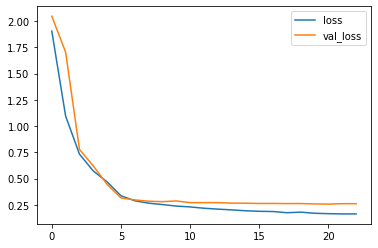

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model_1mfcc.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 90%


In [ ]:
metrics = history_3conv.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 95%


In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model_3conv.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

NameError: ignored

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model_mfcc.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')


Test set accuracy: 94%


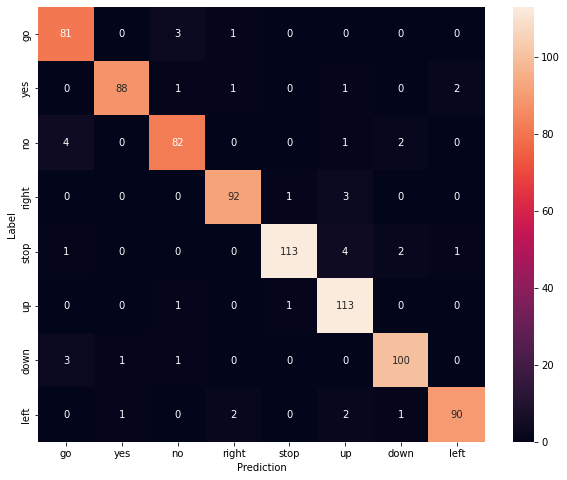

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Spectrogram shape: (98, 257)
number of mel_bands 257
mel_spectrogram_shape (98, 40)


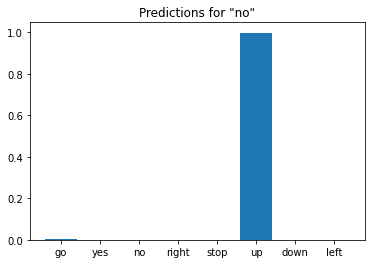

In [ ]:
sample_file = data_dir/'no/0132a06d_nohash_1.wav'
#sample_file = data_dir/'go/004ae714_nohash_0.wav'
#sample_file = data_dir/'left/00b01445_nohash_0.wav'
sample_ds =  preprocess_meldataset([str(sample_file)])


for spectrogram, label in sample_ds.batch(1):
  prediction = model_mfcc(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()


Spectrogram shape: (98, 257)
number of mel_bands 257
mel_spectrogram_shape (98, 40)


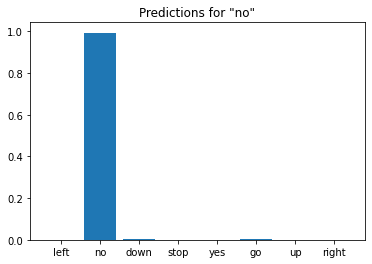

In [ ]:
#run inference

sample_file = data_dir/'no/0132a06d_nohash_1.wav'
#sample_file = data_dir/'go/004ae714_nohash_0.wav'
#sample_file = data_dir/'left/00b01445_nohash_0.wav'
sample_ds =  preprocess_meldataset([str(sample_file)])


for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()



In [ ]:

#run inference

sample_file = data_dir/'no/0132a06d_nohash_1.wav'
#sample_file = data_dir/'go/004ae714_nohash_0.wav'
#sample_file = data_dir/'left/00b01445_nohash_0.wav'
sample_ds = preprocess_mfccdataset([str(sample_file)])


for spectrogram, label in sample_ds.batch(1):
  prediction = model_inf(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()


In [ ]:
for mfcc, _ in mfcc_ds.take(1):
  input_shape = mfcc.shape
print('Input shape:', input_shape)
num_labels = len(commands)
model_1mfcc = create_1convmodel(mfcc_ds,True,num_labels,dropout_rate=0.5)
model_1mfcc.summary()

Input shape: (98, 40, 1)
Input shape: (98, 40, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 98, 40, 1)         3         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 33, 64)        8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
flatten_3 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 61960     
_________________________________________________________________
dens

In [ ]:

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()
def lr_scheduler(epoch, lr):
    if epoch > 5:
        lr = 0.0001
        return lr
    return lr


model_1mfcc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=100000,
#    decay_rate=0.96,
#    staircase=True)

EPOCHS = 100
history = model_1mfcc.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
               tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),]
)





Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 8s 73ms/step - loss: 1.6564 - accuracy: 0.3769 - val_loss: 1.8160 - val_accuracy: 0.2775
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 7s 68ms/step - loss: 0.9870 - accuracy: 0.6413 - val_loss: 1.5867 - val_accuracy: 0.3500
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 7s 68ms/step - loss: 0.7095 - accuracy: 0.7467 - val_loss: 1.0580 - val_accuracy: 0.6237
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 7s 68ms/step - loss: 0.5534 - accuracy: 0.8023 - val_loss: 0.7652 - val_accuracy: 0.7350
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0010000000474

In [ ]:
y_pred = np.argmax(model_1mfcc.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')


Test set accuracy: 86%


In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
model_1cnn_tstride8 = build_1cnnmodel(mfcc_ds,32,40,padding='same',pool1=(1,3), pool2=(1,1),dropout_rate1=0.5, dropout_rate2=0.5,
                    strides1=(8,1),strides2=(1,1),cnn1_features=54,cnn2_features=32,dnn_features1=128, dnn_features2=32,
                    kernel1_size=(16,8),kernel2_size=(5,4))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 40, 1)         0         
_________________________________________________________________
normalization_4 (Normalizati (None, 32, 40, 1)         3         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 40, 54)         6966      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 13, 54)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 4, 13, 54)         216       
_________________________________________________________________
flatten_4 (Flatten)          (None, 2808)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)               

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 5s 40ms/step - loss: 0.2891 - accuracy: 0.8980 - val_loss: 0.4888 - val_accuracy: 0.8275
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 4s 38ms/step - loss: 0.2371 - accuracy: 0.9187 - val_loss: 0.5638 - val_accuracy: 0.8313
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 4s 38ms/step - loss: 0.2071 - accuracy: 0.9294 - val_loss: 0.4895 - val_accuracy: 0.8500
Epoch 00003: early stopping


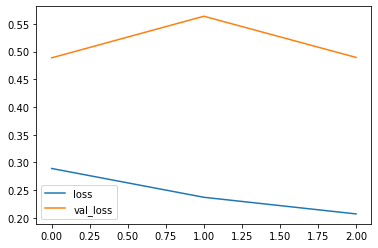

In [ ]:
compile_model(model_1cnn_tstride8,0.001)
history_tstride8 = train(model_1cnn_tstride8,callbacks)
plot_accuracy(history_tstride8)

In [ ]:
y_pred = np.argmax(model_1cnn_tstride8.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 82%


In [ ]:
model_cnn_tstride8_dr = build_2cnnmodel(mfcc_ds,98,40,padding='same',pool1=(1,3), pool2=(1,1),dropout_rate1=0.25, dropout_rate2=0.5,
                    strides1=(1,1),strides2=(1,1),cnn1_features=64,cnn2_features=64,dnn_features1=128, dnn_features2=32,
                    kernel1_size=(20,8),kernel2_size=(10,4))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_5 (Resizing)        (None, 98, 40, 1)         0         
_________________________________________________________________
normalization_6 (Normalizati (None, 98, 40, 1)         3         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 98, 40, 64)        10304     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 98, 13, 64)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 98, 13, 64)        256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 98, 13, 64)        163904    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 98, 13, 64)       

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 302s 3s/step - loss: 1.2825 - accuracy: 0.5587 - val_loss: 0.8084 - val_accuracy: 0.7713
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 301s 3s/step - loss: 0.4119 - accuracy: 0.8628 - val_loss: 0.5723 - val_accuracy: 0.8050
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 302s 3s/step - loss: 0.2529 - accuracy: 0.9167 - val_loss: 0.4748 - val_accuracy: 0.8288
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
100/100 [==============================] - 301s 3s/step - loss: 0.1882 - accuracy: 0.9347 - val_loss: 0.3262 - val_accuracy: 0.9112
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0010000000474

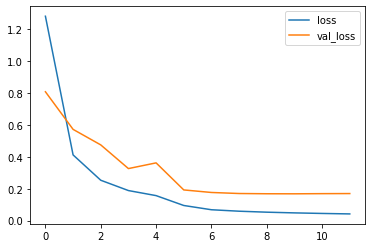

In [ ]:
compile_model(model_cnn_tstride8_dr,0.001)
history_tstride8_dr = train(model_cnn_tstride8_dr,callbacks)
plot_accuracy(history_tstride8_dr)

In [ ]:

test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model_cnn_tstride8_dr.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 94%


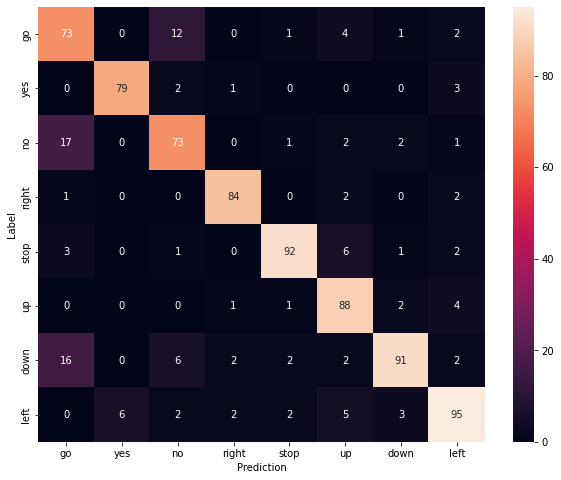

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()